# Project Definition

The goal of this project is to classify Yelp Reviews into 1 star or 5 star categories based off of the text context in the reviews. The concepts are natural language processing using the Multinomial Naive Bayes Classifier.

The Yelp Review Data Set from Kaggle will be used. Each observation in this data set is a review of a particular business by a particular user. 

The "stars" column is the number of stars (1 through 5) assigned by the reviewer to the business. (Higher stars is better.) In other words, it is the rating of the business by the person who wrote the review.

The "cool" column is the number of "cool" votes this review received from other Yelp users. 

All reviews start with 0 "cool" votes, and there is no limit to how many "cool" votes a review can receive. In other words, it is a rating of the review itself, not a rating of the business.

The "useful" and "funny" columns are similar to the "cool" column.

# Initiation

In [18]:
#data manipulation
import numpy as np
import pandas as pd

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

#machine learning
from sklearn.feature_extraction.text import CountVectorizer #Vectorize text data
from sklearn.naive_bayes import MultinomialNB #classifier 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

#metrics
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
yelp = pd.read_csv('yelp.csv')
yelp.head()

,business_id,date,review_id,stars,text,type,user_id,cool,useful,funny
0,9yKzy9PApeiPPOUJEtnvkg,2011-01-26,fWKvX83p0-ka4JS3dc6E5A,5,My wife took me here on my birthday for breakf...,review,rLtl8ZkDX5vH5nAx9C3q5Q,2,5,0
1,ZRJwVLyzEJq1VAihDhYiow,2011-07-27,IjZ33sJrzXqU-0X6U8NwyA,5,I have no idea why some people give bad review...,review,0a2KyEL0d3Yb1V6aivbIuQ,0,0,0
2,6oRAC4uyJCsJl1X0WZpVSA,2012-06-14,IESLBzqUCLdSzSqm0eCSxQ,4,love the gyro plate. Rice is so good and I als...,review,0hT2KtfLiobPvh6cDC8JQg,0,1,0
3,_1QQZuf4zZOyFCvXc0o6Vg,2010-05-27,G-WvGaISbqqaMHlNnByodA,5,"Rosie, Dakota, and I LOVE Chaparral Dog Park!!...",review,uZetl9T0NcROGOyFfughhg,1,2,0
4,6ozycU1RpktNG2-1BroVtw,2012-01-05,1uJFq2r5QfJG_6ExMRCaGw,5,General Manager Scott Petello is a good egg!!!...,review,vYmM4KTsC8ZfQBg-j5MWkw,0,0,0


In [4]:
yelp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
business_id    10000 non-null object
date           10000 non-null object
review_id      10000 non-null object
stars          10000 non-null int64
text           10000 non-null object
type           10000 non-null object
user_id        10000 non-null object
cool           10000 non-null int64
useful         10000 non-null int64
funny          10000 non-null int64
dtypes: int64(4), object(6)
memory usage: 781.3+ KB


In [5]:
yelp.describe()

,stars,cool,useful,funny
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.777500,0.876800,1.409300,0.701300
std,1.214636,2.067861,2.336647,1.907942
min,1.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,1.000000,0.000000
75%,5.000000,1.000000,2.000000,1.000000
max,5.000000,77.000000,76.000000,57.000000


In [6]:
#create new column containing # of words in text column to view review length
yelp['text length'] = yelp['text'].apply(len)

# Exploratory Data Analysis

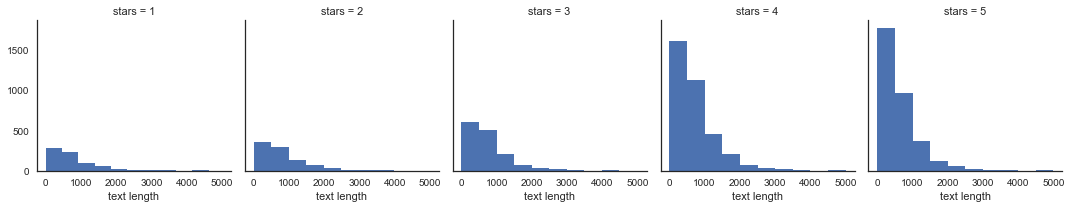

In [7]:
g = sns.FacetGrid(yelp, col='stars')
g.map(plt.hist, 'text length')

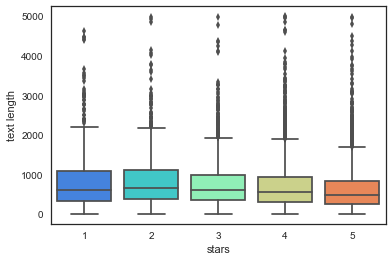

In [8]:
sns.boxplot(x='stars',y='text length',data=yelp,palette='rainbow')

On average, the text length of the 5 star reviews tends to be shorter than star reviews. However there are a lot of outliers that we need to be aware of.

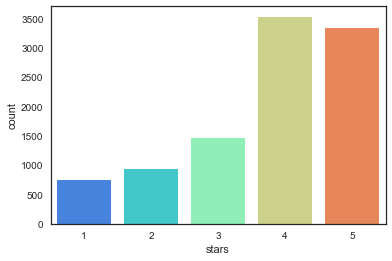

In [9]:
sns.countplot(x='stars', data=yelp, palette='rainbow')

In [13]:
#mean number of votes for each category grouped by each star rating
stars = yelp.groupby('stars').mean()
stars

,cool,useful,funny,text length
stars,,,,
1,0.576769,1.604806,1.056075,826.515354
2,0.719525,1.563107,0.875944,842.256742
3,0.788501,1.306639,0.694730,758.498289
4,0.954623,1.395916,0.670448,712.923142
5,0.944261,1.381780,0.608631,624.999101


In [11]:
stars.corr()

,cool,useful,funny,text length
cool,1.000000,-0.743329,-0.944939,-0.857664
useful,-0.743329,1.000000,0.894506,0.699881
funny,-0.944939,0.894506,1.000000,0.843461
text length,-0.857664,0.699881,0.843461,1.000000


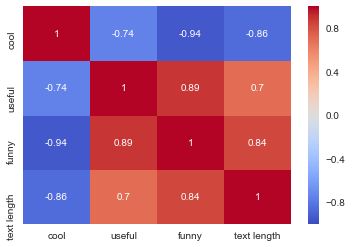

In [12]:
sns.heatmap(stars.corr(),cmap='coolwarm',annot=True)

Though we can see the correlation between text length and the different votes that can be cast, we don't really know how or why people use the voting categories. We can't extract too much intuitively from this heat map, so we'll keep moving forward.

# Training a NB Model

## Predictions without Text Processing

In [19]:
#Vectorizer will transform the text column X into a spare matrix 
#of token word counts
CV = CountVectorizer()

#Create a dataframe containing only 1 and 5 star reviews as defined in our goal.
yelp_class = pd.DataFrame(data=yelp[(yelp['stars'] == 1) | (yelp['stars'] == 5)])

#declare features and labels
X = yelp_class['text']
y = yelp_class['stars']

#Transform X and overwrite using Vectorizer fit transform function
X = CV.fit_transform(X)

#Split features and labels into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [21]:
#Create instance of multinomial naive bayes classifier
nb = MultinomialNB()

#fit model to training data
nb.fit(X_train, y_train)

#predict labels using predict function on test data
pred = nb.predict(X_test)

In [22]:
print(confusion_matrix(y_test, pred))
print('\n')
print(classification_report(y_test, pred))

[[165  74]
 [ 31 956]]


             precision    recall  f1-score   support

          1       0.84      0.69      0.76       239
          5       0.93      0.97      0.95       987

avg / total       0.91      0.91      0.91      1226



## Predictions with Text Processing

We'll use a pipeline to streamline the processing of our text fields. We'll set it up to convert strings into sparse matrices, convert the matrices into weighted TF-IDF Scores, and then train our Naive Bayes Classifier on the TF-IDF Scores.

In [23]:
pipeline = Pipeline([
    ('bow', CountVectorizer()), #strings to token integer counts matrix
    ('tfidf', TfidfTransformer()), #integer counts matrix to weighted TF-IDF Score Matrix
    ('classifier', MultinomialNB()) #train Naive Bayes Classifier on TF-IDF vectors
])

In [24]:
features = yelp_class['text'] #features
target = yelp_class['stars'] #labels

F_train, F_test, t_train, t_test = train_test_split(features, target, test_size=0.33, random_state=101)

In [25]:
pipeline.fit(F_train, t_train)

Pipeline(steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...f=False, use_idf=True)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [26]:
#predictions using our pipeline
predT = pipeline.predict(F_test)

In [27]:
print(confusion_matrix(t_test, predT))
print('\n')
print(classification_report(t_test, predT))

[[   0  247]
 [   0 1102]]


             precision    recall  f1-score   support

          1       0.00      0.00      0.00       247
          5       0.82      1.00      0.90      1102

avg / total       0.67      0.82      0.73      1349



C:\Users\mtavarez\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Conclusion

Converting our data using TF-IDF Scores actually made the scores worse (besides 5 star recall), which shows that more processing is not necessarily a better thing. Looking into the underlying math may shed some light as to why the classifier handled the vectorized text matrices better than the TF-IDF score matrices.